In [62]:
# Load swiss temperature data

import pandas as pd
import glob

path = "data/swiss"
filenames = glob.glob(path + "/*.txt")
dfs = []
N = len(filenames)
for filename in filenames:
    with open(filename, encoding="Windows-1252") as f:
        content = f.readlines()
        station = content[5].split(None, 1)[1][:-1]
        altitude = content[6].split()[3]
        latitude = int(content[7].split()[1][:-1]) + float(content[7].split()[2][:-1]) / 60
        longitude = int(content[7].split()[5][:-1]) + float(content[7].split()[6][:-1]) / 60
    df = pd.read_table(
        filename,
        encoding="Windows-1252",
        delim_whitespace=True,
        skiprows=27,
    )
    df["Station"] = station
    df["Altitude"] = altitude
    df["Latitude"] = latitude
    df["Longitude"] = longitude
    dfs.append(df)

df_all = pd.concat(dfs, ignore_index=True)
df_all.head()


,Year,Month,Temperature,Precipitation,Station,Altitude,Latitude,Longitude
0,1864,1,-4.5,40.8,Altdorf,438,46.886667,8.621667
1,1864,2,-0.4,38.0,Altdorf,438,46.886667,8.621667
2,1864,3,5.4,31.6,Altdorf,438,46.886667,8.621667
3,1864,4,7.2,155.1,Altdorf,438,46.886667,8.621667
4,1864,5,12.6,103.9,Altdorf,438,46.886667,8.621667


C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_6760\4213903666.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax1.scatter(data_1960_1990_july.mean()["Longitude"], data_1960_1990_july.mean()["Latitude"], c=data_1960_1990_july.mean()["Temperature"], cmap="coolwarm", vmin=-10, vmax=25)
C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_6760\4213903666.py:17: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  im = ax2.scatter(data_1960_1990_january.mean()["Longitude"], data_1960_1990_january.mean()["Latitude"], c=data_1960_1990_january.mean()["Temperature"], cmap="coolwarm", vmin=-10, vmax=25)


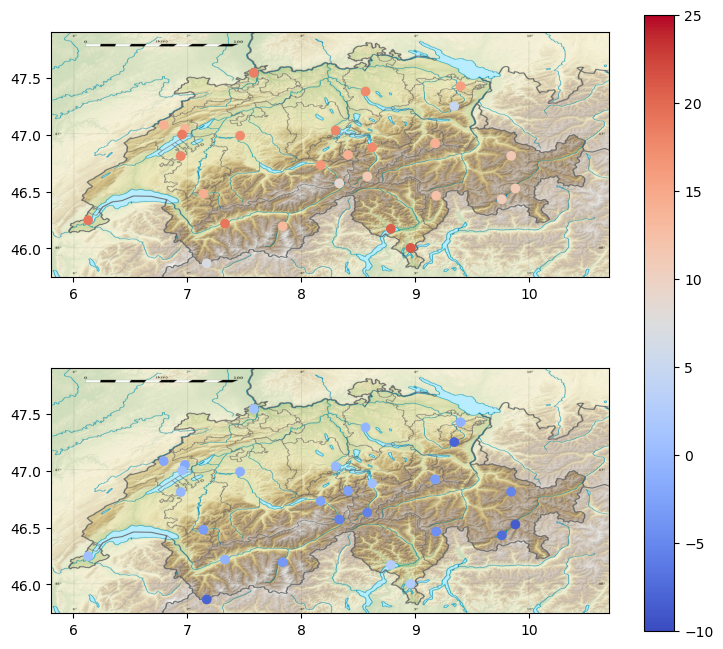

In [60]:
import matplotlib.pyplot as plt

data_1960_1990_january = df_all[(df_all["Year"] >= 1960) & (df_all["Year"] <= 1990) & (df_all["Month"] == 1)].groupby("Station")
data_1960_1990_july = df_all[(df_all["Year"] >= 1960) & (df_all["Year"] <= 1990) & (df_all["Month"] == 7)].groupby("Station")
# print(data_1960_1990_july.mean())

img = plt.imread("data/swiss/Switzerland_relief_location_map.jpg")
plt.figure(figsize=(9, 8))
ax1 = plt.subplot(2, 1, 1)
ax1.imshow(img, zorder=0, extent=[5.8, 10.7, 45.75, 47.9])
ax1.scatter(data_1960_1990_july.mean()["Longitude"], data_1960_1990_july.mean()["Latitude"], c=data_1960_1990_july.mean()["Temperature"], cmap="coolwarm", vmin=-10, vmax=25)
# plt.colorbar()
# plt.show()

ax2 = plt.subplot(2, 1, 2)
ax2.imshow(img, zorder=0, extent=[5.8, 10.7, 45.75, 47.9])
im = ax2.scatter(data_1960_1990_january.mean()["Longitude"], data_1960_1990_january.mean()["Latitude"], c=data_1960_1990_january.mean()["Temperature"], cmap="coolwarm", vmin=-10, vmax=25)
plt.colorbar(im, ax=[ax1, ax2])
plt.show()


C:\Users\Xiaoyang Ma\AppData\Local\Temp\ipykernel_6760\325024427.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  t_january = data_1960_1990_january.mean()["Temperature"].values


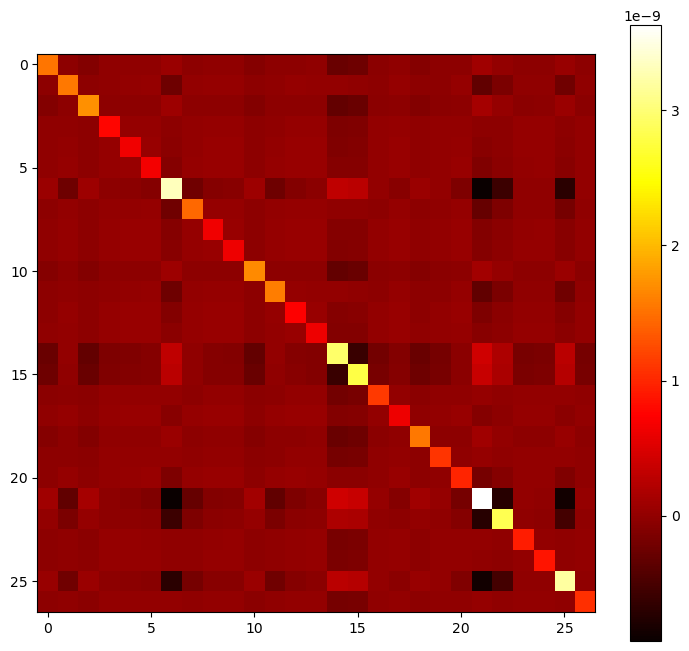

[[ 1.54061137e-09 -2.98603953e-11 -9.15735515e-11 -1.62138629e-11
  -1.19531199e-11 -1.69150697e-11  5.63608664e-11 -3.04680869e-11
  -1.59552468e-11 -1.39674304e-11 -8.68174697e-11 -2.96116623e-11
  -2.04237664e-11 -1.20695754e-11 -2.79903732e-10 -2.47653657e-10
  -3.80094189e-11 -1.32378103e-11 -7.39802366e-11 -3.47452944e-11
  -2.73099584e-11  9.50163847e-11  1.56899271e-11 -2.42077717e-11
  -2.10126791e-11  4.32306746e-11 -3.19895874e-11]
 [-2.98603953e-11  1.55634411e-09 -3.09338683e-11 -3.46228748e-12
   1.08424156e-11  2.66320469e-11 -2.44281901e-10  3.59815817e-12
   2.54370209e-11  2.18982238e-11 -3.08072839e-11 -6.19066896e-12
   2.91900737e-11  1.43918575e-11  3.43865906e-12 -5.78374228e-12
  -2.13238478e-11  1.99818720e-11 -2.99515574e-11 -1.97609743e-11
   2.61813365e-11 -3.23536044e-10 -1.52266673e-10 -1.28106347e-11
  -9.77603633e-12 -2.15851955e-10 -1.82635960e-11]
 [-9.15735515e-11 -3.09338683e-11  1.71823298e-09 -2.82229561e-11
  -2.24336131e-11 -2.54392953e-11  7.913

In [101]:
import cvxpy as cp
import numpy as np

t_january = data_1960_1990_january.mean()["Temperature"].values
# print(t_january)

alpha = 0.1
beta = 2
y = cp.Variable(N)
y_0 = t_january
Lap = cp.Variable((N, N), PSD=True)

for cnt in range(20):
    constraint = [cp.sum(Lap, axis=0) == np.zeros((N,))]
    objective = cp.Minimize(alpha * cp.quad_form(y_0, Lap) + beta * cp.norm(Lap, "fro") ** 2)
    prob = cp.Problem(objective, constraint)
    prob.solve()
    Lap_0 = Lap.value
    # plt.figure(figsize=(9, 8))
    # plt.imshow(Lap_0, cmap='hot', interpolation='nearest')
    # plt.colorbar()
    # plt.show()
    Lap_0 = Lap_0 - np.eye(N) * np.min(np.linalg.eigvals(Lap_0))
    # print(np.sum(Lap_0, axis=0))
    objective2 = cp.Minimize(cp.sum_squares(y - t_january) + alpha * cp.quad_form(y, Lap_0))
    prob2 = cp.Problem(objective2)
    prob2.solve()
    y_0 = y.value

plt.figure(figsize=(9, 8))
plt.imshow(Lap_0, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()
print(Lap_0)

In [112]:
print(data_1960_1990_january["Altitude"].mean())

Station
Altdorf                     1.414318e+91
Andermatt                  4.629495e+121
Basel / Binningen           1.020375e+91
Bern / Zollikofen           1.785657e+91
Chaumont                   3.664883e+121
Château-d'Oex              3.316461e+121
Col du Grand St-Bernard    7.974991e+121
Davos                      5.142450e+121
Elm                         3.093416e+91
Engelberg                  3.342270e+121
Genève / Cointrin           1.327134e+91
Grimsel Hospiz             6.387736e+121
Grächen                    5.177937e+121
La Chaux-de-Fonds          3.280973e+121
Locarno / Monti             1.185056e+91
Lugano                      8.815267e+90
Luzern                      1.465982e+91
Meiringen                   1.901902e+91
Neuchâtel                   1.566082e+91
Payerne                     1.886502e+76
S. Bernardino              5.287626e+121
Samedan                    5.513455e+121
Segl-Maria                 5.819937e+121
Sion                        1.556395e+91
St. Gall